In [ ]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [2]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [3]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [4]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...


# Train, validate split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [6]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [7]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train


## Balance training data

In [8]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [9]:
df[df.data_type=='train'].head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train
5,1481060,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,0,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,train


In [10]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [11]:
df_train.head()

,clean_message,label
1526,"MENTION Sveiki! Lūdzu, atsūti DM savu pieslēgu...",0
567,Tiešraide jau pēc NMBR minūtēm! MENTION - MENT...,0
260,"ES ATVAINOJOS, VAI IR KĀDS IZDEVĪGĀKS PAR LATV...",0
560,Tiešraide jau pēc NMBR minūtēm! MENTION - HK P...,0
777,SEB ievieš Latvijā pirmo indeksu plānu pensiju...,0


In [12]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs MENT...,0
1911,MENTION Sveiks! Tas neattiecas uz mūsu ekspert...,1
505,"MENTION MENTION Starpcitu, Maxima tirgo labus ...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,MENTION Спасибо за мнение.^el,0


# Tokenizer "sentence-transformers/LaBSE"

In [13]:
tokenizer = AutoTokenizer.from_pretrained("./../labse_bert_model", do_lower_case=True)

## Find popular Emoji

In [15]:
import re

emoji_str = "😀 😃 😄 😁 😆 😅 😂 🤣 😊 😇 🙂 🙃 😉 😌 😍 🥰 😘 😗 😙 😚 😋 😛 😝 😜 🤪 🤨 🧐 🤓 😎 🤩 🥳 😏 😒 😞 😔 😟 😕 🙁 ☹️ 😣 😖 😫 😩 🥺 😢 😭 😤 😠 😡 🤬 🤯 😳 🥵 🥶 😱 😨 😰 😥 😓 🤗 🤔 🤭 🤫 🤥 😶 😐 😑 😬 🙄 😯 😦 😧 😮 😲 🥱 😴 🤤 😪 😵 🤐 🥴 🤢 🤮 🤧 😷 🤒 🤕 😺 😸 😹 😻 😼 😽 🙀 😿 😾 💩 👋 🤚 🖐 ✋ 🖖 👌 🤏 ✌️ 🤞 🤟 🤘 🤙 👈 👉 👆 🖕 👇 ☝️ 👍 👎 ✊ 👊 🤛 🤜 👏 🙌 👐 🤲 🤝 🙏'👋🏻 🤚🏻 🖐🏻 ✋🏻 🖖🏻 👌🏻 🤏🏻 ✌🏻 🤞🏻 🤟🏻 🤘🏻 🤙🏻 👈🏻 👉🏻 👆🏻 🖕🏻 👇🏻 ☝🏻 👍🏻 👎🏻 ✊🏻 👊🏻 🤛🏻 🤜🏻 👏🏻 🙌🏻 👐🏻 🤲🏻 🙏🏻 👋🏼 🤚🏼 🖐🏼 ✋🏼 🖖🏼 👌🏼 🤏🏼 ✌🏼 🤞🏼 🤟🏼 🤘🏼 🤙🏼 👈🏼 👉🏼 👆🏼 🖕🏼 👇🏼 ☝🏼 👍🏼 👎🏼 ✊🏼 👊🏼 🤛🏼 🤜🏼 👏🏼 🙌🏼 👐🏼 🤲🏼 🙏🏼 👋🏽 🤚🏽 🖐🏽 ✋🏽 🖖🏽 👌🏽 🤏🏽 ✌🏽 🤞🏽 🤟🏽 🤘🏽 🤙🏽 👈🏽 👉🏽 👆🏽 🖕🏽 👇🏽 ☝🏽 👍🏽 👎🏽 ✊🏽 👊🏽 🤛🏽 🤜🏽 👏🏽 🙌🏽 👐🏽 🤲🏽 🙏👋🏾 🤚🏾 🖐🏾 ✋🏾 🖖🏾 👌🏾 🤏🏾 ✌🏾 🤞🏾 🤟🏾 🤘🏾 🤙🏾 👈🏾 👉🏾 👆🏾 🖕🏾 👇🏾 ☝🏾 👍🏾 👎🏾 ✊🏾 👊🏾 🤛🏾 🤜🏾 👏🏾 🙌🏾 👐🏾 🤲🏾 🙏 👋🏿 🤚🏿 🖐🏿 ✋🏿 🖖🏿 👌🏿 🤏🏿 ✌🏿 🤞🏿 🤟🏿 🤘🏿 🤙🏿 👈🏿 👉🏿 👆🏿 🖕🏿 👇🏿 ☝🏿 👍🏿 👎🏿 ✊🏿 👊🏿 🤛🏿 🤜🏿 👏🏿 🙌🏿 👐🏿 🤲🏿 🙏🏿 ❤️ 🧡 💛 💚 💙 💜 🖤 🤍 🤎 💔 ❣️ 💕 💞 💓 💗 💖 💘 💝 💟 💑🏻 💑🏼 💑🏽 💑🏾 💑🏿 💏🏻 💏🏼 💏🏽 💏🏾 💏🏿 👨🏻‍❤️‍👨🏻 👨🏻‍❤️‍👨🏼 👨🏻‍❤️‍👨🏽 👨🏻‍❤️‍👨🏾 👨🏻‍❤️‍👨🏿 👨🏼‍❤️‍👨🏻 👨🏼‍❤️‍👨🏼 👨🏼‍❤️‍👨🏽 👨🏼‍❤️‍👨🏾 👨🏼‍❤️‍👨🏿 👨🏽‍❤️‍👨🏻 👨🏽‍❤️‍👨🏼 👨🏽‍❤️‍👨🏽 👨🏽‍❤️‍👨🏾 👨🏽‍❤️‍👨🏿 👨🏾‍❤️‍👨🏻 👨🏾‍❤️‍👨🏼 👨🏾‍❤️‍👨🏽 👨🏾‍❤️‍👨🏾 👨🏾‍❤️‍👨🏿 👨🏿‍❤️‍👨🏻 👨🏿‍❤️‍👨🏼 👨🏿‍❤️‍👨🏽 👨🏿‍❤️‍👨🏾 👨🏿‍❤️‍👨🏿 👩🏻‍❤️‍👨🏻 👩🏻‍❤️‍👨🏼 👩🏻‍❤️‍👨🏽 👩🏻‍❤️‍👨🏾 👩🏻‍❤️‍👨🏿 👩🏻‍❤️‍👩🏻 👩🏻‍❤️‍👩🏼 👩🏻‍❤️‍👩🏽 👩🏻‍❤️‍👩🏾 👩🏻‍❤️‍👩🏿 👩🏼‍❤️‍👨🏻 👩🏼‍❤️‍👨🏼 👩🏼‍❤️‍👨🏽 👩🏼‍❤️‍👨🏾 👩🏼‍❤️‍👨🏿 👩🏼‍❤️‍👩🏻 👩🏼‍❤️‍👩🏼 👩🏼‍❤️‍👩🏽 👩🏼‍❤️‍👩🏾 👩🏼‍❤️‍👩🏿 👩🏽‍❤️‍👨🏻 👩🏽‍❤️‍👨🏼 👩🏽‍❤️‍👨🏽 👩🏽‍❤️‍👨🏾 👩🏽‍❤️‍👨🏿 👩🏽‍❤️‍👩🏻 👩🏽‍❤️‍👩🏼 👩🏽‍❤️‍👩🏽 👩🏽‍❤️‍👩🏾 👩🏽‍❤️‍👩🏿 👩🏾‍❤️‍👨🏻 👩🏾‍❤️‍👨🏼 👩🏾‍❤️‍👨🏽 👩🏾‍❤️‍👨🏾 👩🏾‍❤️‍👨🏿 👩🏾‍❤️‍👩🏻 👩🏾‍❤️‍👩🏼 👩🏾‍❤️‍👩🏽 👩🏾‍❤️‍👩🏾 👩🏾‍❤️‍👩🏿 👩🏿‍❤️‍👨🏻 👩🏿‍❤️‍👨🏼 👩🏿‍❤️‍👨🏽 👩🏿‍❤️‍👨🏾 👩🏿‍❤️‍👨🏿 👩🏿‍❤️‍👩🏻 👩🏿‍❤️‍👩🏼 👩🏿‍❤️‍👩🏽 👩🏿‍❤️‍👩🏾 👩🏿‍❤️‍👩🏿 🧑🏻‍❤️‍🧑🏼 🧑🏻‍❤️‍🧑🏽 🧑🏻‍❤️‍🧑🏾 🧑🏻‍❤️‍🧑🏿 🧑🏼‍❤️‍🧑🏻 🧑🏼‍❤️‍🧑🏽 🧑🏼‍❤️‍🧑🏾 🧑🏼‍❤️‍🧑🏿 🧑🏽‍❤️‍🧑🏻 🧑🏽‍❤️‍🧑🏼 🧑🏽‍❤️‍🧑🏾 🧑🏽‍❤️‍🧑🏿 🧑🏾‍❤️‍🧑🏻 🧑🏾‍❤️‍🧑🏼 🧑🏾‍❤️‍🧑🏽 🧑🏾‍❤️‍🧑🏿 🧑🏿‍❤️‍🧑🏻 🧑🏿‍❤️‍🧑🏼 🧑🏿‍❤️‍🧑🏽 🧑🏿‍❤️‍🧑🏾 👨🏻‍❤️‍💋‍👨🏻 👨🏻‍❤️‍💋‍👨🏼 👨🏻‍❤️‍💋‍👨🏽 👨🏻‍❤️‍💋‍👨🏾 👨🏻‍❤️‍💋‍👨🏿 👨🏼‍❤️‍💋‍👨🏻 👨🏼‍❤️‍💋‍👨🏼 👨🏼‍❤️‍💋‍👨🏽 👨🏼‍❤️‍💋‍👨🏾 👨🏼‍❤️‍💋‍👨🏿 👨🏽‍❤️‍💋‍👨🏻 👨🏽‍❤️‍💋‍👨🏼 👨🏽‍❤️‍💋‍👨🏽 👨🏽‍❤️‍💋‍👨🏾 👨🏽‍❤️‍💋‍👨🏿 👨🏾‍❤️‍💋‍👨🏻 👨🏾‍❤️‍💋‍👨🏼 👨🏾‍❤️‍💋‍👨🏽 👨🏾‍❤️‍💋‍👨🏾 👨🏾‍❤️‍💋‍👨🏿 👨🏿‍❤️‍💋‍👨🏻 👨🏿‍❤️‍💋‍👨🏼 👨🏿‍❤️‍💋‍👨🏽 👨🏿‍❤️‍💋‍👨🏾 👨🏿‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👨🏻 👩🏻‍❤️‍💋‍👨🏼 👩🏻‍❤️‍💋‍👨🏽 👩🏻‍❤️‍💋‍👨🏾 👩🏻‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👩🏻 👩🏻‍❤️‍💋‍👩🏼 👩🏻‍❤️‍💋‍👩🏽 👩🏻‍❤️‍💋‍👩🏾 👩🏻‍❤️‍💋‍👩🏿 👩🏼‍❤️‍💋‍👨🏻 👩🏼‍❤️‍💋‍👨🏼 👩🏼‍❤️‍💋‍👨🏽 👩🏼‍❤️‍💋‍👨🏾 👩🏼‍❤️‍💋‍👨🏿 👩🏼‍❤️‍💋‍👩🏻 👩🏼‍❤️‍💋‍👩🏼 👩🏼‍❤️‍💋‍👩🏽 👩🏼‍❤️‍💋‍👩🏾 👩🏼‍❤️‍💋‍👩🏿 👩🏽‍❤️‍💋‍👨🏻 👩🏽‍❤️‍💋‍👨🏼 👩🏽‍❤️‍💋‍👨🏽 👩🏽‍❤️‍💋‍👨🏾 👩🏽‍❤️‍💋‍👨🏿 👩🏽‍❤️‍💋‍👩🏻 👩🏽‍❤️‍💋‍👩🏼 👩🏽‍❤️‍💋‍👩🏽 👩🏽‍❤️‍💋‍👩🏾 👩🏽‍❤️‍💋‍👩🏿 👩🏾‍❤️‍💋‍👨🏻 👩🏾‍❤️‍💋‍👨🏼 👩🏾‍❤️‍💋‍👨🏽 👩🏾‍❤️‍💋‍👨🏾 👩🏾‍❤️‍💋‍👨🏿 👩🏾‍❤️‍💋‍👩🏻 👩🏾‍❤️‍💋‍👩🏼 👩🏾‍❤️‍💋‍👩🏽 👩🏾‍❤️‍💋‍👩🏾 👩🏾‍❤️‍💋‍👩🏿 👩🏿‍❤️‍💋‍👨🏻 👩🏿‍❤️‍💋‍👨🏼 👩🏿‍❤️‍💋‍👨🏽 👩🏿‍❤️‍💋‍👨🏾 👩🏿‍❤️‍💋‍👨🏿 👩🏿‍❤️‍💋‍👩🏻 👩🏿‍❤️‍💋‍👩🏼 👩🏿‍❤️‍💋‍👩🏽 👩🏿‍❤️‍💋‍👩🏾 👩🏿‍❤️‍💋‍👩🏿 🧑🏻‍❤️‍💋‍🧑🏼 🧑🏻‍❤️‍💋‍🧑🏽 🧑🏻‍❤️‍💋‍🧑🏾 🧑🏻‍❤️‍💋‍🧑🏿 🧑🏼‍❤️‍💋‍🧑🏻 🧑🏼‍❤️‍💋‍🧑🏽 🧑🏼‍❤️‍💋‍🧑🏾 🧑🏼‍❤️‍💋‍🧑🏿 🧑🏽‍❤️‍💋‍🧑🏻 🧑🏽‍❤️‍💋‍🧑🏼 🧑🏽‍❤️‍💋‍🧑🏾 🧑🏽‍❤️‍💋‍🧑🏿 🧑🏾‍❤️‍💋‍🧑🏻 🧑🏾‍❤️‍💋‍🧑🏼 🧑🏾‍❤️‍💋‍🧑🏽 🧑🏾‍❤️‍💋‍🧑🏿 🧑🏿‍❤️‍💋‍🧑🏻 🧑🏿‍❤️‍💋‍🧑🏼 🧑🏿‍❤️‍💋‍🧑🏽 🧑🏿‍❤️‍💋‍🧑🏾 👭 🧑‍🤝‍🧑 👬 👫 👩‍❤️‍👩 💑 👨‍❤️‍👨 👩‍❤️‍👨 👩‍❤️‍💋‍👩 💏 👨‍❤️‍💋‍👨 👩‍❤️‍💋‍👨 👪 👨‍👩‍👦 👨‍👩‍👧 👨‍👩‍👧‍👦 👨‍👩‍👦‍👦 👨‍👩‍👧‍👧 👨‍👨‍👦 👨‍👨‍👧 👨‍👨‍👧‍👦 👨‍👨‍👦‍👦 👨‍👨‍👧‍👧 👩‍👩‍👦 👩‍👩‍👧 👩‍👩‍👧‍👦 👩‍👩‍👦‍👦 👩‍👩‍👧‍👧 👨‍👦 👨‍👦‍👦 👨‍👧 👨‍👧‍👦 👨‍👧‍👧 👩‍👦 👩‍👦‍👦 👩‍👧 👩‍👧‍👦 👩‍ 👧‍👧 💋"
emoji_list = emoji_str.split(' ')
emoji_regex = '|'.join(emoji_list)

In [16]:
all_emoji = []
for message in df.clean_message:
    foundEmoji = re.findall(emoji_regex, message)
    for emoji in foundEmoji:
        all_emoji.append(emoji)

print(len(all_emoji))

107


In [17]:
import collections

counter=collections.Counter(all_emoji)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]

[('😂', 12), ('🤔', 9), ('😁', 9), ('👍', 7), ('👉', 6), ('🙄', 6), ('😀', 5), ('😉', 5), ('😎', 5), ('😊', 4), ('🤗', 3), ('😅', 3), ('👏', 3), ('❤️', 3), ('😥', 2), ('😵', 2), ('😍', 2), ('😆', 2), ('🤘', 2), ('🤬', 2), ('🙂', 2), ('😖', 1), ('🤥', 1), ('☝️', 1), ('🙁', 1), ('🤣', 1), ('😳', 1), ('🙌', 1), ('👌', 1), ('🤓', 1), ('😌', 1), ('🤢', 1), ('👇', 1), ('😜', 1)]


In [18]:
c=[('😂', 6968), ('😭', 4638), ('🤣', 2528), ('🙏', 1916), ('🥺', 1084), ('😩', 1058), ('🤔', 903), ('🥰', 899), ('🥴', 869), ('👏', 840), ('😍', 838), ('🙄', 775), ('🙌', 672), ('💙', 639), ('😅', 568), ('💜', 543), ('💕', 540), ('😊', 509), ('👍', 477), ('😘', 474), ('😔', 464), ('💔', 454), ('😒', 446), ('🙃', 425), ('😎', 398), ('😉', 388), ('😁', 365), ('😢', 359), ('😌', 355), ('🖤', 347), ('😆', 310), ('🤗', 307), ('😳', 298), ('🥳', 292), ('✊', 289), ('😤', 289), ('💛', 288), ('😬', 282), ('🤬', 281), ('👇', 271), ('😡', 266), ('👌', 265), ('🤩', 265), ('💖', 259), ('😫', 255), ('💋', 251), ('🤍', 250), ('💚', 231), ('💗', 217), ('🙂', 212), ('😞', 206), ('😷', 202), ('🤯', 202), ('😀', 193), ('😴', 188), ('😋', 185), ('😏', 179), ('🤞', 174), ('😜', 174), ('👉', 168), ('🤘', 154), ('😪', 154), ('🤤', 154), ('😑', 152), ('🤪', 152), ('😐', 141), ('😱', 139), ('😄', 132), ('👊', 128), ('🤢', 122), ('🤨', 121), ('🧐', 120), ('🥶', 116), ('😕', 115), ('💩', 113), ('😇', 112), ('🤮', 109), ('🥵', 106), ('🤧', 104), ('👋', 103), ('👎', 99), ('😖', 97), ('🤓', 96), ('😃', 96), ('🥱', 94), ('💞', 93), ('😓', 91), ('🤝', 90), ('🧡', 89), ('😹', 86), ('🖕', 85), ('😝', 84), ('😣', 75), ('🤫', 71), ('😰', 71), ('😥', 70), ('🤭', 70), ('💓', 59), ('😠', 58), ('😮', 55)]
most_common_values= [word for word, word_count in c]

In [19]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

10

### Find max length for tokenizer

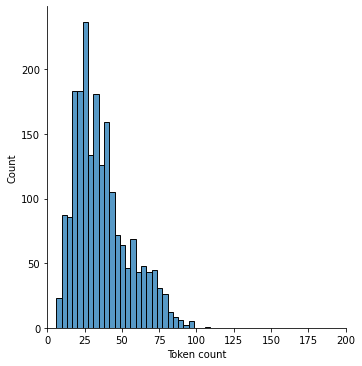

In [20]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [21]:
max_length = 120

### Encode messages

In [22]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [ ]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [ ]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [ ]:
# len(dataset_train), len(dataset_val)

# Model "LaBSE" pytorch

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("./../labse_bert_model", num_labels = 3)

Some weights of the model checkpoint at ./../labse_bert_model were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [25]:
model.resize_token_embeddings(len(tokenizer))

Embedding(501163, 768)

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [27]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [28]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [29]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [30]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [31]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate model trained on PNN dataset on LV Twitter data

In [32]:
model.load_state_dict(torch.load('modelsEmoji-pnn/finetuned_LaBSE_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
_, predictions, true_vals = evaluate(dataloader_validation)

from sklearn.metrics import classification_report, confusion_matrix

preds_flat = np.argmax(predictions, axis=1).flatten()

print(classification_report(true_vals, preds_flat))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Validating::   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.26      0.35       145
           1       0.20      0.48      0.28        62
           2       0.32      0.26      0.28        97

    accuracy                           0.31       304
   macro avg       0.35      0.33      0.30       304
weighted avg       0.39      0.31      0.31       304



predicted                  
                  neutral positive negative
actual neutral         38       74       33
       positive        11       30       21
       negative        23       49       25

# Train on Latvian Twitter data

In [35]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsEmojiTwttrPNN/finetuned_LaBSE_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0288640314882451


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.9379362523555755
F1 Score (Weighted): 0.6074067218395374
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.54      0.64       145
           1       0.41      0.71      0.52        62
           2       0.62      0.61      0.61        97

    accuracy                           0.60       304
   macro avg       0.60      0.62      0.59       304
weighted avg       0.65      0.60      0.61       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         79       40       26
       positive         8       44       10
       negative        15       23       59


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8486078869212758


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8320737183094025
F1 Score (Weighted): 0.6649088102367295
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.70       145
           1       0.54      0.71      0.61        62
           2       0.61      0.70      0.65        97

    accuracy                           0.66       304
   macro avg       0.65      0.67      0.65       304
weighted avg       0.69      0.66      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         89       25       31
       positive         6       44       12
       negative        16       13       68


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7434514164924622


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7837831854820252
F1 Score (Weighted): 0.6596568370862697
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       145
           1       0.52      0.79      0.63        62
           2       0.67      0.57      0.61        97

    accuracy                           0.66       304
   macro avg       0.65      0.67      0.65       304
weighted avg       0.68      0.66      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         96       29       20
       positive         6       49        7
       negative        26       16       55


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6687924590977755


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7564062237739563
F1 Score (Weighted): 0.6720605836125851
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       145
           1       0.56      0.81      0.66        62
           2       0.66      0.59      0.62        97

    accuracy                           0.67       304
   macro avg       0.66      0.69      0.66       304
weighted avg       0.69      0.67      0.67       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         97       25       23
       positive         5       50        7
       negative        25       15       57


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6355598894032565


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7478810131549836
F1 Score (Weighted): 0.6867297973152187
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       145
           1       0.56      0.79      0.65        62
           2       0.67      0.65      0.66        97

    accuracy                           0.68       304
   macro avg       0.67      0.70      0.68       304
weighted avg       0.70      0.68      0.69       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         96       26       23
       positive         5       49        8
       negative        21       13       63


# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsBaseTwttrPNN/finetuned_BERT_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])